In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!unrar x "/content/gdrive/MyDrive/data/classification_dataset.rar" "/content/gdrive/My Drive/data/" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/MyDrive/data/classification_dataset.rar

Creating    /content/gdrive/My Drive/data/classification_dataset      OK
Creating    /content/gdrive/My Drive/data/classification_dataset/all  OK
Extracting  /content/gdrive/My Drive/data/classification_dataset/all/100_1477154436.jpg       0%  OK 
Extracting  /content/gdrive/My Drive/data/classification_dataset/all/100_1477154442.jpg       0%  OK 
Extracting  /content/gdrive/My Drive/data/classification_dataset/all/100_1477154448.jpg       0%  OK 
Extracting  /content/gdrive/My Drive/data/classification_dataset/all/100_1477154454.jpg       0%  OK 
Extracting  /content/gdrive/My Drive/data/classification_dataset/all/100_1477154460.jpg       0%  OK 
Extracting  /content/gdrive/My Drive/data/classification_dataset/all/100_1477154466.jpg       0%  OK 
Extracting  /content/gdrive/My Drive/data/clas

In [3]:
from pathlib import Path

In [4]:
input_path = Path('/content/gdrive/MyDrive/data/classification_dataset/all')
im_size = 320

In [5]:
image_files = list(input_path.glob('*.jpg'))

In [6]:
def read_file(fname):
    # Read image
    im = Image.open(fname)

    # Resize
    im.thumbnail((im_size, im_size))

    # Convert to numpy array
    im_array = np.asarray(im)

    # Get target
    target = int(fname.stem.split('_')[0])

    return im_array, target

In [7]:
images = []
targets = []

for image_file in tqdm_notebook(image_files):
    image, target = read_file(image_file)
    
    images.append(image)
    targets.append(target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [13]:
X = (np.array(images).astype(np.float32) / 127.5) - 1
y_cls = np.array(targets)

In [9]:
images = np.array(images)
labels = np.array(targets)

In [10]:
print(images.shape, labels.shape)

(3059, 240, 320, 3) (3059,)


In [11]:
def extract_coins(img, to_size=100):
    """
    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
     # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)

        frames.append(resized)

    return np.array(frames), radiuses

In [14]:
scaled = []
scaled_labels = []
radiuses = []
for nominal, image in zip(labels, images):
    prepared, radius = extract_coins(image)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)
        radiuses.append(radius[0])

# Create dataframe with data and pickle it
data = pd.DataFrame({'label': scaled_labels, 'radius': radiuses, 'image': scaled})
data.to_pickle('file.pickle')

In [13]:
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

In [15]:
data = pd.read_pickle('file.pickle')

In [16]:
data = pd.read_pickle('file.pickle')

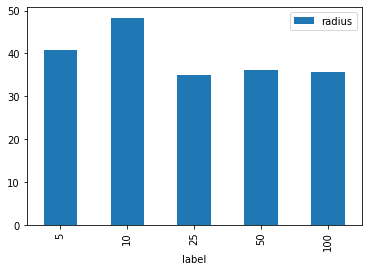

In [17]:
data.groupby('label').mean().plot.bar()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.radius.values, data.label.values, test_size=0.20, random_state=42)
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [20]:
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
clf.score(X_test, y_test)

0.6428571428571429

In [23]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier

In [42]:
knn = KNeighborsClassifier(n_neighbors=25)
  
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [43]:
knn.score(X_test, y_test)

0.6428571428571429

In [39]:
print(knn.predict(X_test))

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100]


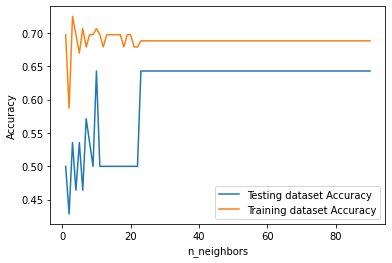

In [44]:
neighbors = np.arange(1, 91)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
      
    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
clf = RandomForestClassifier(n_estimators = 157)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.5714285714285714
